## 1. Data Acquisition

In [93]:
import pandas as pd

In [94]:
athlete_events = pd.read_csv('athlete_events.csv')
noc_regions = pd.read_csv('noc_regions.csv')

In [95]:
athlete_events.head()
# NOC = national olympic committee code
# so the dataset has the grain: player per event
# this is like the fact table containing all the data and measurements

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [96]:
noc_regions.head()
# looks like these two datasets are interconnected with the (NOC) column

,NOC,region,notes
0,AFG,Afghanistan,NaN
1,AHO,Curacao,Netherlands Antilles
2,ALB,Albania,NaN
3,ALG,Algeria,NaN
4,AND,Andorra,NaN


In [97]:
athlete_events.info()
# is the age supposed to be a float ?
# wow ... there are more than 200 thousand records

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271116 non-null  int64  
 1   Name    271116 non-null  object 
 2   Sex     271116 non-null  object 
 3   Age     261642 non-null  float64
 4   Height  210945 non-null  float64
 5   Weight  208241 non-null  float64
 6   Team    271116 non-null  object 
 7   NOC     271116 non-null  object 
 8   Games   271116 non-null  object 
 9   Year    271116 non-null  int64  
 10  Season  271116 non-null  object 
 11  City    271116 non-null  object 
 12  Sport   271116 non-null  object 
 13  Event   271116 non-null  object 
 14  Medal   39783 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 31.0+ MB


In [98]:
noc_regions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   NOC     230 non-null    object
 1   region  227 non-null    object
 2   notes   21 non-null     object
dtypes: object(3)
memory usage: 5.5+ KB


##  2. Database Design

In [99]:
# Now to build the schema of the relational database, I have some questions:
# 1. Do (NOC) have a one-to-one relationship with the team .. and is its (region) column different from the (team) column in the athlete_events df ?
# 2. Can an athelete change teams in different seasons ?
# 3. Is the column (games) a combination of (year), (season) ?
# 4. can a (region) have more than one (NOC) ?


In [100]:
# 1. Do (NOC) have a one-to-one relationship with the team .. and is its (region) column different from the (team) column in the athlete_events df ?


stage = athlete_events.drop_duplicates(['NOC', 'Team'])
filt = stage['NOC'] == 'FRA' # as an example
print(stage['Team'][filt].head(20))
# by the previous query we know that 'NOC' doesn't have a one-to-one relationship with the team column ... one NOC can have multiple teams related to it
# also, the 'region' is not the same as the 'team'

98                                               France
778                                            France-1
1187                                           France-2
2761     Union des Socits Franais de Sports Athletiques
3995                                           France-3
4016                                          Martha-27
4017                                           Martha-1
4769                          Socit Nautique de Bayonne
4931                                     Cupidon Viking
4932                                         Damoiselle
4962                                              USFSA
7844                          Club Nautique de Dieppe-5
8884                                              EA II
9820                                             Guyoni
10909                                      Carabinier-5
10910                                   Pettit-Poucet-6
10911                                     Carabinier-15
15736                             Racing Club de

In [101]:
# 2. Can an athelete change teams in different seasons ?

# the reason for asking this question is finding out whether to put the team as an attribute for the athelete (that's not changing or changing very slowly) or as a fact that changes in the fact table
stage = athlete_events.drop_duplicates(['ID', 'Team'])
stage2 = stage.groupby('ID')
print(stage2[['ID','Team']].size().max()) # looks like some player have switched teams 8 times !

# I think it's better to have the (team) as a fact table attribute !

8


The Schema:
1. dim_atheltes table: athelte_idNOT NULLNOT NULLNOT NULLNOT NULLNOT NULLNOT NULLNOT NULLNOT NULLNOT NULLNOT NULLNOT NULLNOT NULLNOT NULLNOT NULLNOT NULLNOT NULLNOT NULL NOT NULL NOT NULL NOT NULL NOT NULL NOT NULL NOT NULL, name, sex (PK: athelete_id)
2. dim_events table: event_id, name, year, season, games, sport (PK: event_id -> synthetic key based on (name + games) columns)
3. fct_athlete_events table: athelte_id, event_id, team_id, athelte_age, athelte_height, athlete_weight, medal (PK: athelete_id, event_id)
4. dim_NOC table: NOC, region, notes
5. dim_team table: team, city, NOC (PK: team)


here I've taken events, teams away from the main athlete_events table + I've made (NOC) an attribute for team itself
measurements in the fact table = athelte_age, athelte_height, athlete_weight, medal
team_id = team

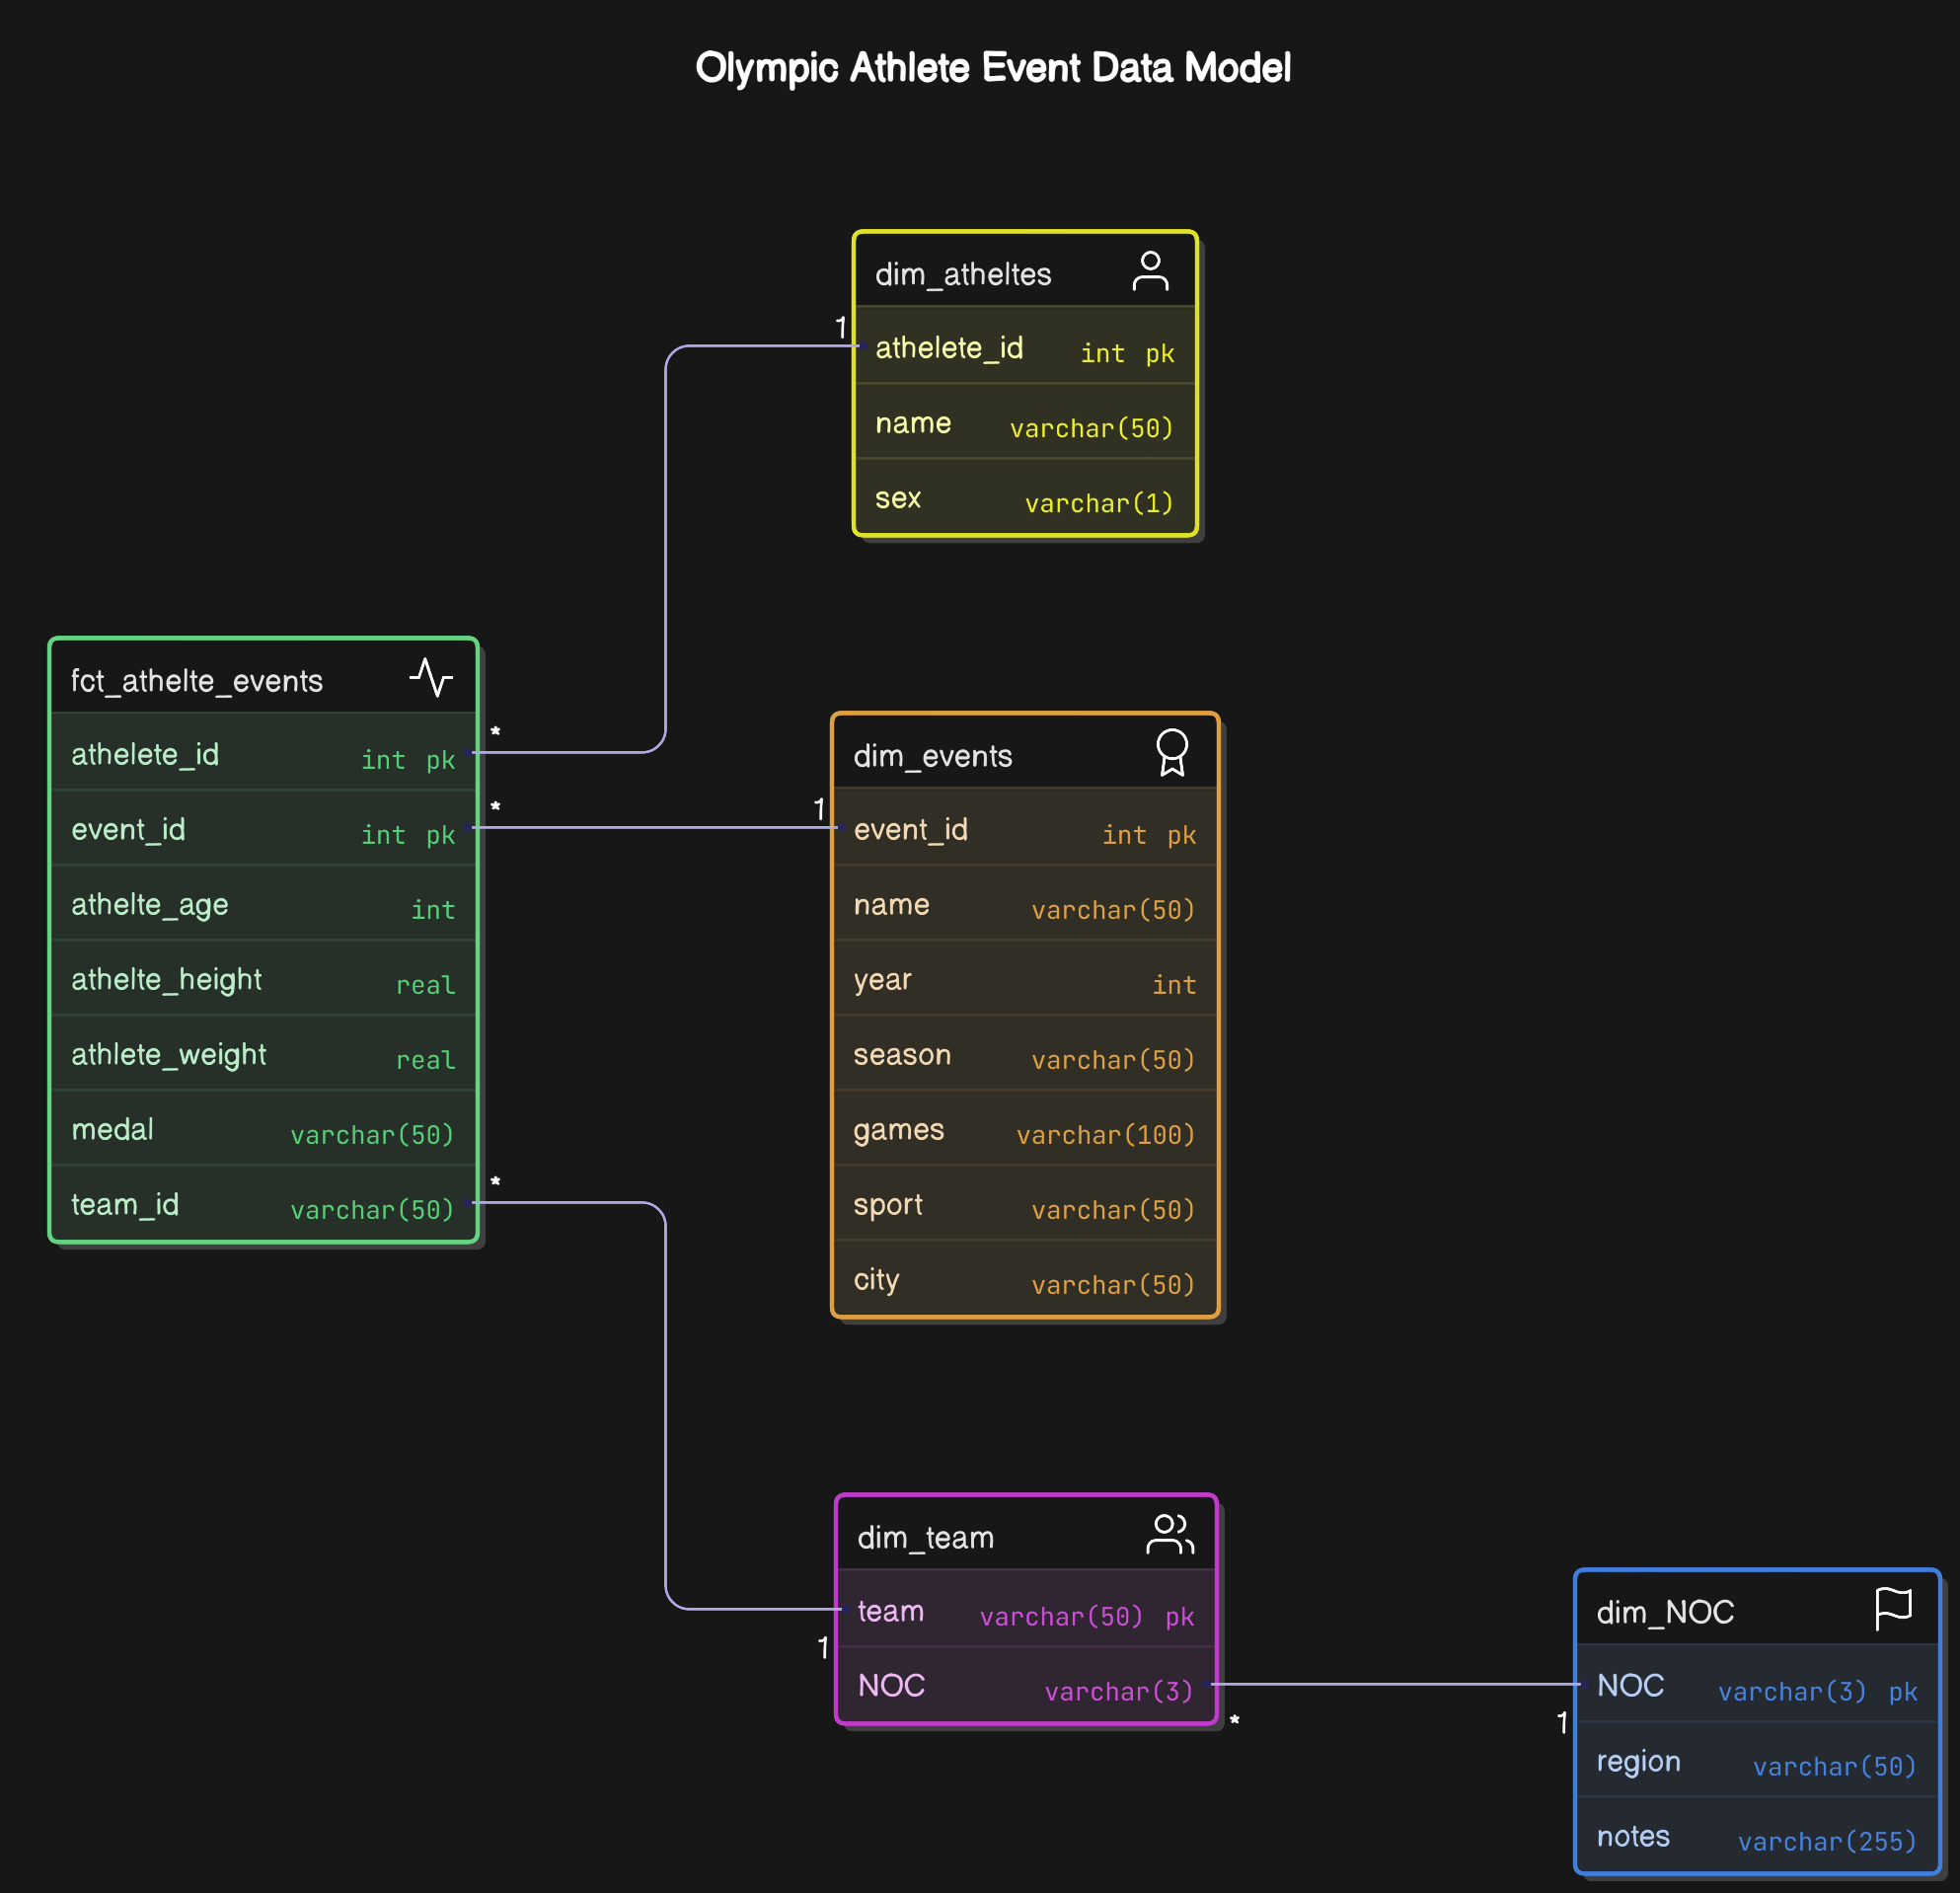

## 3. Database Setup

In [102]:
# now let's create the database
from sqlalchemy import create_engine, text, MetaData

engine = create_engine('sqlite:///olympic_athlete_events.db')
metadata = MetaData()
metadata.reflect(engine)
metadata.drop_all(engine)

In [103]:
    
sql_statement = """
    CREATE TABLE dim_athletes (
    athelete_id INTEGER PRIMARY KEY,
    name VARCHAR(50) NOT NULL,
    sex VARCHAR(1) NOT NULL,
    CONSTRAINT chk_sex CHECK (sex IN ('M', 'F'))
    );

    CREATE TABLE dim_events (
    event_id INTEGER PRIMARY KEY,
    name VARCHAR(50) NOT NULL,
    year INTEGER NOT NULL,
    season VARCHAR(50) NOT NULL,
    games VARCHAR(100) NOT NULL,
    sport VARCHAR(50) NOT NULL,
    CONSTRAINT chk_season CHECK (season IN ('Summer', 'Winter'))
    );

    CREATE TABLE fct_athlete_events (
    athelete_id INTEGER NOT NULL,
    event_id INTEGER NOT NULL,
    team_id VARCHAR(50) NOT NULL,
    athelte_age INTEGER,
    athelte_height REAL,
    athlete_weight REAL,
    medal VARCHAR(50) NOT NULL,
    PRIMARY KEY (athelete_id, event_id),
    FOREIGN KEY (athelete_id) REFERENCES dim_athletes(athelete_id),
    FOREIGN KEY (event_id) REFERENCES dim_events(event_id),
    FOREIGN KEY (team_id) REFERENCES dim_teams(team_id)
    );

    CREATE TABLE dim_NOC (
    NOC VARCHAR(3) PRIMARY KEY,
    region VARCHAR(50),
    notes VARCHAR(255)
    );

    CREATE TABLE dim_teams (
    team_id VARCHAR(50) PRIMARY KEY,
    city VARCHAR(50) NOT NULL,
    NOC VARCHAR(3) NOT NULL,
    FOREIGN KEY (NOC) REFERENCES dim_NOC(NOC)
    );
    """

with engine.connect() as conn:
    for statement in sql_statement.split(';'):
        conn.execute(text(statement))


In [104]:
# let's make sure the schema was built
with engine.connect() as conn:
    results = conn.execute(text('SELECT * FROM dim_teams'))
    print(results.keys())

RMKeyView(['team_id', 'city', 'NOC'])


## 4. Data Cleaning And Transformation

In [105]:
# now let's handle messing data

print(athlete_events.shape)
print(athlete_events.isna().sum())
# looks like the three (Age, Height, Weight) have missing values because it was not recorded
# on the other hand, not all players have (medals) in each event

(271116, 15)
ID             0
Name           0
Sex            0
Age         9474
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     231333
dtype: int64


In [106]:
# handling (medal) column
print(athlete_events['Medal'].value_counts()) # before

athlete_events['Medal'] = athlete_events['Medal'].fillna('Nothing')
print('#'*50)

print(athlete_events['Medal'].value_counts()) # after


Medal
Gold      13372
Bronze    13295
Silver    13116
Name: count, dtype: int64
##################################################
Medal
Nothing    231333
Gold        13372
Bronze      13295
Silver      13116
Name: count, dtype: int64


In [107]:
# what is the cause of the (Age, Weight, Height) columns having a lot of (nan)s ?

# to answer that question let's ask another: is there a relation between the age and the (weight and height data completeness) ?
stage = athlete_events.groupby("Age")
print(stage['Weight'].median().sort_index(ascending=False))

Age
97.0     NaN
96.0     NaN
88.0     NaN
84.0     NaN
81.0     NaN
        ... 
14.0    50.0
13.0    50.0
12.0    55.0
11.0    50.0
10.0     NaN
Name: Weight, Length: 74, dtype: float64


In [108]:
stage = athlete_events.groupby("Age")
print(stage['Height'].median().sort_index(ascending=False).head(60))

Age
97.0      NaN
96.0      NaN
88.0      NaN
84.0      NaN
81.0      NaN
80.0      NaN
77.0      NaN
76.0      NaN
75.0      NaN
74.0      NaN
73.0      NaN
72.0      NaN
71.0    168.0
70.0    175.5
69.0    162.0
68.0    178.0
67.0    168.0
66.0    171.5
65.0    177.5
64.0    173.0
63.0    169.0
62.0    178.0
61.0    178.0
60.0    171.0
59.0    178.0
58.0    172.0
57.0    174.0
56.0    175.0
55.0    171.0
54.0    175.0
53.0    174.0
52.0    172.5
51.0    175.0
50.0    175.0
49.0    174.0
48.0    175.0
47.0    174.0
46.0    174.0
45.0    175.0
44.0    175.0
43.0    174.0
42.0    175.0
41.0    175.0
40.0    175.0
39.0    177.0
38.0    176.0
37.0    175.5
36.0    176.0
35.0    176.0
34.0    177.0
33.0    177.0
32.0    177.0
31.0    177.0
30.0    177.0
29.0    177.0
28.0    177.0
27.0    176.0
26.0    176.0
25.0    176.0
24.0    176.0
Name: Height, dtype: float64


In [109]:
df = athlete_events[athlete_events['Age']> 66.0][['Age','Weight','Height']]
print(df.shape)
print(df.isna().sum())
print('#'*50)
df2 = athlete_events[athlete_events['Age'].isna()][['Age','Weight','Height']]
print(df2.shape)
print(df2.isna().sum())


# most people that have more than 66 years: have no records for (Weight, Height)
# most people that don't have the (Age) recorded don't have their (Weight, Height) recorded also

(239, 3)
Age         0
Weight    231
Height    230
dtype: int64
##################################################
(9474, 3)
Age       9474
Weight    8612
Height    8597
dtype: int64


In [ ]:
# let's leave the three (Age, Weight, Height) without dealing with messing data in order to
# 1. not lose valuable data completness trend informations
# 2. not lose other related data by deleting the rows with messing (Age, Weight, Height) values
# 3. be able to analyze data recording completeness over the years

In [111]:
# what about the messing data in the noc_regions dataset
print(noc_regions.shape)
print(noc_regions.isna().sum())

(230, 3)
NOC         0
region      3
notes     209
dtype: int64


In [112]:
filt = noc_regions['region'].isna()
noc_regions[filt]

# these three NOCs don't have a region specific to them ...

,NOC,region,notes
168,ROT,NaN,Refugee Olympic Team
208,TUV,NaN,Tuvalu
213,UNK,NaN,Unknown


In [113]:
athlete_events.info()
# no nead to change datatypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271116 non-null  int64  
 1   Name    271116 non-null  object 
 2   Sex     271116 non-null  object 
 3   Age     261642 non-null  float64
 4   Height  210945 non-null  float64
 5   Weight  208241 non-null  float64
 6   Team    271116 non-null  object 
 7   NOC     271116 non-null  object 
 8   Games   271116 non-null  object 
 9   Year    271116 non-null  int64  
 10  Season  271116 non-null  object 
 11  City    271116 non-null  object 
 12  Sport   271116 non-null  object 
 13  Event   271116 non-null  object 
 14  Medal   271116 non-null  object 
dtypes: float64(3), int64(2), object(10)
memory usage: 31.0+ MB


In [114]:
athlete_events = athlete_events.rename(columns={'ID':'Athlete_id', 'Team':'Team_id', 'Age':'Athlete_age', 'Weight':'Athlete_weight', 'Height':'Athlete_height', 'Event':'Event_name' })
athlete_events.columns

Index(['Athlete_id', 'Name', 'Sex', 'Athlete_age', 'Athlete_height',
       'Athlete_weight', 'Team_id', 'NOC', 'Games', 'Year', 'Season', 'City',
       'Sport', 'Event_name', 'Medal'],
      dtype='object')

In [115]:
# changing the structure to match the schema of the database
athlete_events['Event_id'] = athlete_events['Event_name'] + ' ' + athlete_events['Games']

athletes = athlete_events[['Athlete_id', 'Name', 'Sex']].drop_duplicates()
teams = athlete_events[['Team_id', 'NOC']].drop_duplicates()
events = athlete_events[['Event_id', 'Event_name', 'Year', 'Season', 'Games', 'City', 'Sport']].drop_duplicates()
noc = noc_regions.drop_duplicates() # no change
fct_athlete_events = athlete_events[['Athlete_id', 'Team_id', 'Event_id', 'Athlete_age', 'Athlete_weight', 'Athlete_height', 'Medal']].drop_duplicates()

In [116]:
# bulk loading the data into the database
import sqlite3
with sqlite3.connect('olympic_athlete_events.db') as conn:
    athletes.to_sql('dim_athletes', conn, if_exists='replace', index=False)
    noc.to_sql('dim_NOC', conn, if_exists='replace', index=False)
    teams.to_sql('dim_teams', conn, if_exists='replace', index=False)
    events.to_sql('dim_events', conn, if_exists='replace', index=False)
    fct_athlete_events.to_sql('fct_athlete_events', conn, if_exists='replace', index=False)


## 5. Data analysis

let's answer some questions about the data:

IN SQL
1. Which country won the most gold medals in the Winter Olympics?
2. What is the distribution of athlete ages in different sports?
3. List the top 10 athletes with the most total medals.
4. Which cities have hosted both the Summer and Winter Olympics?
5. Analyze the trend of athlete participation over the years.


IN PANDAS
1. Which country won the most silver medals in the Summer Olympics?
2. How has the gender distribution of athletes changed across different Olympic Games?
3. Which sports have seen the most significant increase (or decrease) in participation over time?
4. Analyze age data for all the sports 
5. How complete is the age, weight, and height data over time, and are there noticeable gaps or biases in data collection across different eras or sports?

### IN SQL

In [128]:
# 1. Which country won the most gold medals in the Winter Olympics?
from IPython.display import display

query = """
SELECT Team_id, COUNT(Medal) as Total_medals
FROM fct_athlete_events f INNER JOIN dim_events e on f.event_id = e.event_id
WHERE Medal = 'Gold' AND season = 'Winter'
GROUP BY Team_id
ORDER BY COUNT(Medal) DESC
LIMIT 1
"""
with engine.connect() as conn:
    result = conn.execute(text(query)).fetchall()
    display(result)

[('Canada', 289)]

In [118]:
# 2. What is the distribution of athlete ages in different sports?
query = """
SELECT 
    Sport,
    MIN(Athlete_age) as min,
    AVG(Athlete_age) as average,
    MAX(Athlete_age) as max
FROM
    fct_athlete_events f inner join dim_events e on f.event_id = e.event_id
GROUP BY Sport ORDER BY Sport
"""
with engine.connect() as conn:
    result = conn.execute(text(query)).fetchall()
    display(result)

[('Aeronautics', 26.0, 26.0, 26.0),
 ('Alpine Skiing', 14.0, 23.20546223288767, 55.0),
 ('Alpinism', 22.0, 38.8125, 57.0),
 ('Archery', 14.0, 27.935226264418812, 71.0),
 ('Art Competitions', 14.0, 44.71959638874137, 97.0),
 ('Athletics', 12.0, 25.161223238328844, 52.0),
 ('Badminton', 16.0, 25.67124227865477, 44.0),
 ('Baseball', 16.0, 26.240761478163495, 44.0),
 ('Basketball', 16.0, 25.324597701149425, 40.0),
 ('Basque Pelota', 26.0, 26.0, 26.0),
 ('Beach Volleyball', 18.0, 29.122340425531913, 41.0),
 ('Biathlon', 17.0, 26.53291087489779, 45.0),
 ('Bobsleigh', 15.0, 29.11018084393838, 54.0),
 ('Boxing', 15.0, 23.054808867167043, 41.0),
 ('Canoeing', 15.0, 25.504400260756192, 48.0),
 ('Cricket', 21.0, 29.333333333333332, 44.0),
 ('Croquet', 15.0, 33.733333333333334, 58.0),
 ('Cross Country Skiing', 15.0, 26.006155198944825, 49.0),
 ('Curling', 17.0, 31.41252699784017, 58.0),
 ('Cycling', 14.0, 24.77580946757209, 49.0),
 ('Diving', 12.0, 22.48144064682102, 51.0),
 ('Equestrianism', 16.0

In [127]:
# 3. List the top 10 athletes with the most total medals.
query = """
SELECT Name, COUNT(Medal) as Total_medals
FROM dim_athletes a inner join fct_athlete_events f on a.Athlete_id = f.Athlete_id
GROUP BY Name
ORDER BY COUNT(Medal) DESC
LIMIT 10
"""
with engine.connect() as conn:
    result = conn.execute(text(query)).fetchall()
    display(result)

[('Heikki Ilmari Savolainen', 39),
 ('Joseph "Josy" Stoffel', 38),
 ('Ioannis Theofilakis', 36),
 ('Takashi Ono', 33),
 ('Andreas Wecker', 32),
 ('Alexandros Theofilakis', 32),
 ('Michel Mathiot', 31),
 ('Johann "Hans" Sauter', 31),
 ('Alfred August "Al" Jochim', 31),
 ('Yordan Yovchev Yovchev', 30)]

In [136]:
# 4. Which cities have hosted both the Summer and Winter Olympics?
query = """
WITH stage AS (
    SELECT City, 
    COUNT(
        CASE 
            WHEN Season = 'Summer' THEN 1 ELSE 0
        END
    ) as Summer, 
    COUNT(
        CASE 
            WHEN Season = 'Winter' THEN 1 ELSE 0
        END
    ) as Winter
    FROM dim_events
    GROUP BY City
)
SELECT City
FROM stage
WHERE Summer != 0 AND Winter != 0
"""
with engine.connect() as conn:
    result = conn.execute(text(query)).fetchall()
    display(result)

[('Albertville',),
 ('Amsterdam',),
 ('Antwerpen',),
 ('Athina',),
 ('Atlanta',),
 ('Barcelona',),
 ('Beijing',),
 ('Berlin',),
 ('Calgary',),
 ('Chamonix',),
 ("Cortina d'Ampezzo",),
 ('Garmisch-Partenkirchen',),
 ('Grenoble',),
 ('Helsinki',),
 ('Innsbruck',),
 ('Lake Placid',),
 ('Lillehammer',),
 ('London',),
 ('Los Angeles',),
 ('Melbourne',),
 ('Mexico City',),
 ('Montreal',),
 ('Moskva',),
 ('Munich',),
 ('Nagano',),
 ('Oslo',),
 ('Paris',),
 ('Rio de Janeiro',),
 ('Roma',),
 ('Salt Lake City',),
 ('Sankt Moritz',),
 ('Sapporo',),
 ('Sarajevo',),
 ('Seoul',),
 ('Sochi',),
 ('Squaw Valley',),
 ('St. Louis',),
 ('Stockholm',),
 ('Sydney',),
 ('Tokyo',),
 ('Torino',),
 ('Vancouver',)]

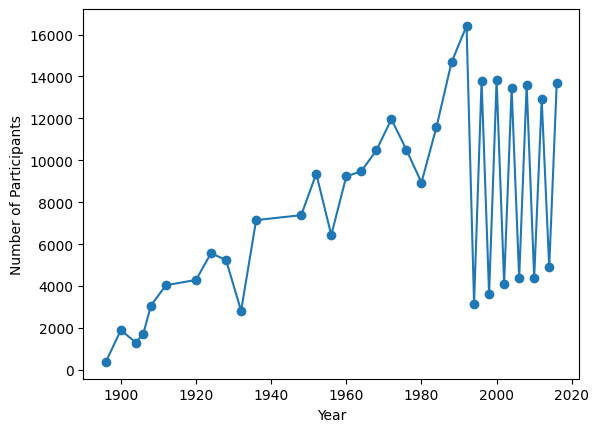

In [153]:
# 5. Analyze the trend of athlete participation over the years.
query = """
SELECT 
    YEAR,
    COUNT(Athlete_id) as participation
FROM dim_events e inner join fct_athlete_events f on e.Event_id = f.Event_id
GROUP BY YEAR
ORDER BY YEAR
"""
with engine.connect() as conn:
    result = conn.execute(text(query)).fetchall()
    years = [year for year, _ in result]
    participation = [participation for _, participation in result]
    plt.plot(years, participation, marker='o')
    plt.xlabel('Year')
    plt.ylabel('Number of Participants')
    df = pd.DataFrame(result) # ready for further analysis

### IN PANDAS

In [122]:
# 1. Which country won the most silver medals in the Summer Olympics?
filt = (athlete_events['Season'] == 'Summer') & (athlete_events['Medal'] == 'Silver')
stage = athlete_events[filt].groupby('NOC')
the_noc = stage['Medal'].size().idxmax()
the_number = stage['Medal'].size().max()
print(f'The NOC with the most silver medals in the summer is {the_noc} with {the_number} medals.')

The NOC with the most silver medals in the summer is USA with 1333 medals.


<Axes: xlabel='Year'>

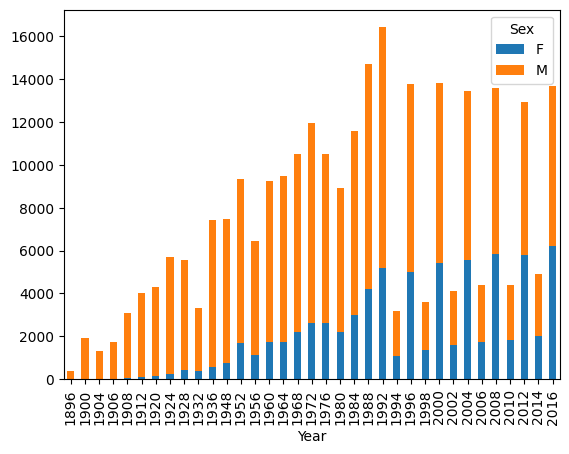

In [123]:
# How has the gender distribution of athletes changed across different Olympic Games?
import matplotlib.pyplot as plt
gender_counts = athlete_events.groupby(['Year', 'Sex']).size().unstack(fill_value=0)
gender_counts.plot(kind='bar', stacked=True)

# males are dominating most of the events

In [124]:
# 3. Which sports have seen the most significant increase (or decrease) in participation over time?
sport_counts = athlete_events.groupby(['Year', 'Sport']).size().reset_index(name="Count")
sport_counts
sport_counts['Year_diff'] = sport_counts.groupby('Sport')['Count'].diff()
top = sport_counts.sort_values(by='Year_diff', ascending=False).head(1)
bottom = sport_counts.sort_values(by='Year_diff', ascending=True).head(1)
print('the sport with the most increase in participation in one year and the most decrease (in order)')

print('#'*50)
print(top)
print('#'*50)
print(bottom)
print('#'*50)
print('Gymnastics participation is really fluctuating !')

the sport with the most increase in participation in one year and the most decrease (in order)
##################################################
     Year       Sport  Count  Year_diff
280  1952  Gymnastics   2391     1331.0
##################################################
     Year       Sport  Count  Year_diff
307  1956  Gymnastics    913    -1478.0
##################################################
Gymnastics participation is really fluctuating !


In [125]:
# 4. Analyze age data for all the sports 

from IPython.display import display # let's try using for displaying the df

combined = events.join(fct_athlete_events, lsuffix='_df1')
result = combined.groupby('Sport')['Athlete_age'].describe()
display(result)

,count,mean,std,min,25%,50%,75%,max
Sport,,,,,,,,
Aeronautics,1.0,26.000000,NaN,26.0,26.00,26.0,26.00,26.0
Alpine Skiing,142.0,23.401408,3.930351,15.0,20.00,23.0,26.00,34.0
Alpinism,3.0,44.333333,15.534907,27.0,38.00,49.0,53.00,57.0
Archery,60.0,31.616667,10.480153,17.0,23.00,28.0,43.00,55.0
Art Competitions,68.0,42.147059,10.988820,20.0,34.75,42.5,47.00,75.0
...,...,...,...,...,...,...,...,...
Tug-Of-War,3.0,30.333333,3.511885,27.0,28.50,30.0,32.00,34.0
Volleyball,28.0,24.607143,3.224206,18.0,22.00,24.5,27.00,30.0
Water Polo,28.0,25.178571,4.722316,20.0,21.00,24.5,28.25,35.0


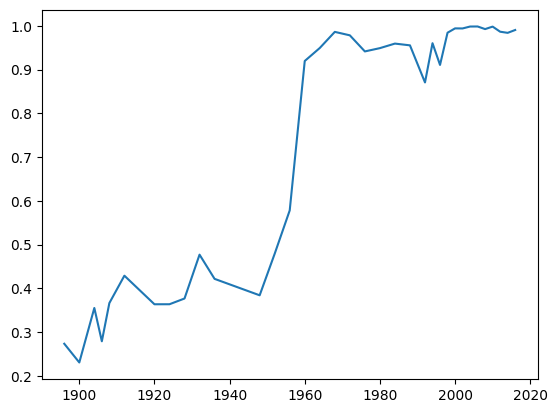

In [152]:
# 5. How complete is the age, weight, and height data over time?

# Answering this question is similar to determining how frequently (NaN) values appear in the data over time
# that's because only the 'age,' 'weight,' and 'height' columns can contain null values in our dataset

All = athlete_events.groupby('Year').size() * 3
Ages = athlete_events.groupby('Year')['Athlete_age'].count()
Weights = athlete_events.groupby('Year')['Athlete_weight'].count()
Heights = athlete_events.groupby('Year')['Athlete_height'].count()

result = (Ages + Weights + Heights) / All

print(plt.plot(result))